# Getting Started with Readout Error Mitigation with mitiq on Braket 

In this notebook, you will learn how to perform readout-error mitigation using [mitiq](https://mitiq.readthedocs.io/en/stable/) with Amazon Braket ProgramSets. This is particularly helpful for superconducting devices (IQM and Rigetti devices), which may contain larger measurement errors. 

### Installing mitiq
>[!WARNING]
>mitiq is distributed under the GPL GNU v3 license, and so is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. Or install `requirement-mitiq.txt`. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [1]:
# !pip install mitiq
try:
    import mitiq  # noqa: F401
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")

Package 'mitiq' is installed.


In [2]:
import os
import sys
import warnings

import numpy as np
from qiskit_braket_provider import to_braket, to_qiskit

from braket.circuits import Circuit

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # get parent directory tools  

from tools.mitigation_tools import apply_readout_twirl
from tools.noise_models import qd_readout as qd
from tools.noise_models import qd_readout_2 as qd2

warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")
np.set_printoptions(linewidth=500, precision=3, suppress=True)

### Readout Error Mitigation

Readout errors occur largely due to challenges in performing projective or POVM measurements on a device, which heavily depend on the particular hardware used and relevant physics and/or timescales. Readout error mitigation, or REM, specifically focuses on correcting these errors. Because of the ubiquity of the problem and the prevelance of superconducting devices, many schemes historically have focused on SC devices. However, different mitigation schemes may be better suited for particular device types, which some architectures having very high readout fidelities. 

Regardless of the device, within a static circuit (i.e. a traditional circuit model), we only have a single layer of measurements, and thus even largely high readout error rates can be permitted at the cost of a constant shot overhead. 

The most [common way](https://mitiq.readthedocs.io/en/stable/guide/rem-5-theory.html) of performing readout error mitigation is to (1) characterize the confusion matrix $C$ of relevant input state and output states, (2) calculate the inverse of this matrix, $C^{-1}$ and then (3) apply the inverse to your measurement results (which w.l.o.g. can be cast as an array) to obtain some error mitigated results. Each of these steps can involve some technical challenges at scale, which we detail below. The [mitiq REM](https://mitiq.readthedocs.io/en/stable/guide/rem.html) page contains numerous useful references related to REM. 

An optional step, which is utilzied in mitiq, is to (4) constrain the modified distribution to the closest probability distribution, using `scipy`.  

##### Note on Post-Selection

Post-selection is also a very common, physically motived error mitigation approach (also relevant to quantum error detection approaches ([McArdle et al.](https://arxiv.org/abs/1807.02467), [Cai et al.](https://arxiv.org/abs/2210.00921), [Sagastizabal](https://arxiv.org/abs/1902.11258)). Note, we can equivalently cast $C$ as some projector $C_P$, where $P$ is a set of bit-strings that obey particlary symmetries. $C$ is not invertible, but we can still consider it as a sort of filter applied to measurement results. mitiq does [support post-selection](https://mitiq.readthedocs.io/en/stable/guide/rem-1-intro.html#apply-postselection) as well. 

#### Import the relevant mitiq functions


In [3]:
from mitiq import MeasurementResult
from mitiq.rem import (
    generate_inverse_confusion_matrix,
    generate_tensored_inverse_confusion_matrix,
    post_select,
    rem_decorator,
)

#### Getting the Confusion Matrix

The confusion matrix can be obtained by preparing a complete set of input states and performing measurement in each basis. This in principle yields the following transition probabilities $C_{oi} = P(o | i)$, where $P(o | i)$ is the conditional probabilities of measuring a state $o$ when preparing $i$. For our purposes, we will have to learn our confusion matrix ourselves, so we do so here: 

In [4]:
num_qubits = 6

## UNCOMMENT_TO_RUN
# num_qubits = 2

dim = 2**num_qubits
results = []
shots = []

for i in range(dim):
    circ = Circuit()
    bstr = f"{i:0{num_qubits}b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz"])
    results.append(qd.run(circ.measure(range(num_qubits)),shots=10000).result().measurement_probabilities)

print(circ) # final state should be all X 



T  : │         0         │  1  │
      ┌─────────────────┐ ┌───┐ 
q0 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q1 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q2 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q3 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q4 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q5 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
T  : │         0         │  1  │


We then populate the confusion matrix in the variable `cm`, which is output below. 

In [5]:
cm = np.zeros((dim,dim))
np.set_printoptions(precision=3,linewidth=400,suppress=True)

for n,meas_results in enumerate(results):
    for k,v in meas_results.items():
        cm[n , int(k,2)] = v

for i in range(dim):
    print(cm[:,i])

[0.74  0.039 0.037 0.002 0.039 0.002 0.002 0.    0.036 0.002 0.002 0.    0.002 0.    0.    0.    0.039 0.002 0.002 0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.036 0.003 0.002 0.    0.002 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.038 0.734 0.002 0.043 0.001 0.035 0.    0.002 0.002 0.038 0.    0.001 0.    0.002 0.    0.    0.002 0.039 0.    0.002 0.    0.002 0.    0.    0.    0.003 0.    0.    0.    0.    0.    0.    0.002 0.04  0.    0.002 0.    0.003 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.036 0.003 0.736 0.036 0.002 0.    0.039 0.003 0.002 0.    0.036 0.002 0.    0.    0.002 0.    0.002 0.    0.037 0.002 0.    0.    0.003 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.001 0.    0.04  0.002 0.    0.   

In [6]:
cm_i = generate_tensored_inverse_confusion_matrix(num_qubits, confusion_matrices=[cm])

Having the inverse confusion matrix, we can then apply this to our circuits.

In [7]:

circ = Circuit().h(0)
for i in range(1,num_qubits):
    circ.cnot(i,i+1)
circ.measure(range(num_qubits))

circ = to_braket(to_qiskit(circ, add_measurements=False), 
                    basis_gates = ["r", "cz"])
# 

raw_results = []

@rem_decorator(inverse_confusion_matrix=cm_i)
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

res = GHZ_res(circ).get_counts()


We can alternatively filter our results using post-selection.

In [8]:
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

ps_res = post_select(GHZ_res(circ), lambda bits: all(bits) or all([not b for b in bits])).get_counts()
print(ps_res)


{'000000': 3816}


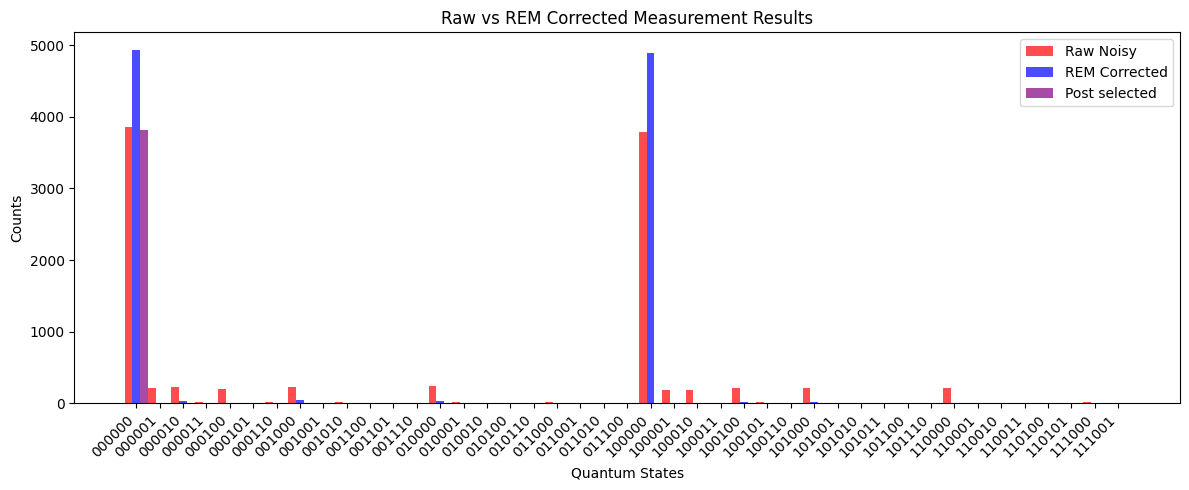

In [9]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

all_states = sorted(set(raw_counts.keys()) | set(corrected_counts.keys()))
raw_values = [raw_counts.get(state, 0) for state in all_states]
corr_values = [corrected_counts.get(state, 0) for state in all_states]
ps_values = [ps_res.get(state, 0) for state in all_states]


plt.figure(figsize=(12,5))
x = range(len(all_states))
width = 0.333
plt.bar([i - width for i in x], raw_values, width, label='Raw Noisy', color='red', alpha=0.7)
plt.bar([i  for i in x], corr_values, width, label='REM Corrected', color='blue', alpha=0.7)
plt.bar([i + width for i in x], ps_values, width, label='Post selected', color='purple', alpha=0.7)
plt.xlabel('Quantum States')
plt.ylabel('Counts')
plt.title('Raw vs REM Corrected Measurement Results')
plt.xticks(x, all_states, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Cost, Accuracy, and Efficiency of REM

Generally, a full characterization over $n-$qubits is only relevant when we expect correlated errors up to some degree $n$. Thus, often we can simplify the number of circuits we need (see [Bravyi et al.](https://arxiv.org/abs/2006.14044) for an example). However, these can potentially bias results if the states have not been averaged over the relevant subsystems, and their performance has some subtle effects. 

Here, we detail two additional features that we use to improve the above naive execution.

#### Characterization via ProgramSets

The first task is to replace job submission with ProgramSets. This allows us to submit many more circuits simultaneously. The above characterization circuits for instance, can be submitted with a single ProgramSet.

In [10]:
# let's get a 6-qubit local readout 
from braket.program_sets import ProgramSet

circuits = []
for i in range(dim):
    circ = Circuit()
    bstr = f"{i:0{num_qubits}b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz"])
    circuits.append(circ.measure(range(6)))

pset = ProgramSet(circuits, shots_per_executable=10000)

result = qd.run(pset).result()
 


The result is to reducing queue times and service overhead time, as well as the total cost by \$0.32 * (64-1) ~ \$19, just from job submission. 

### Simplifying characterization with twirling 

We can further simplify the above procedure somewhat by considering a variant of the readout procedure. ***Iin brief***, we randomize the output measurement channel, and thus remove our input state dependence, reducing $2^n$ input states to 1. This is similar to ideas in [Hashim et al.](Quhttps://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.6.010307), though [earlier works](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) have also used twirling in measurements. The main difference here is in the application of the inverse. 

The measurement POVM in the computational basis can be written as $M_i = \frac{1}{2}(I_i \pm Z_i)$. The measurement channel itself has the form $\mathcal{E}[\rho] = M_0 \rho M_0 + M_1 \rho M_1$. We can effectively "twirl" the measurement operation by inserting Pauli gates before (physically) and after (virtually). For a measurement channel, this will yield an effective bitflip channel.

The main difference here is the cost of learning - in a single configuration we can now learn all the symmetrized transition coeffieints to precision $1/\sqrt{N}$. Another way to think of this is that most states have similar transition rates from 0 to 1 and 1 to 0. If we randomly flip these for all states, then we effectively average it out so that in expectation they are the same. 


#### Executing with Braket

We use a built-in function, `tools/apply_readout_twirl`, which generates the random twirled permutations and keeps track of the Pauli twirls associated it with. 

In [11]:

circuit = Circuit().z(0).z(1).z(2).z(3)

variants, paulis = apply_readout_twirl(circuit, num_samples = 5)

print(variants[-1])
print(paulis)


T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ Z ├─┤ Y ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ Z ├─┤ X ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ Z ├─┤ I ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ Z ├─┤ Y ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
('XYIZ', 'XXXY', 'ZIYX', 'XYIY', 'YXIY')


Now, let's see how performing twirls can standardize our distribution. Using $10^7$ shots, we look at $N_{twirls} = 10^m$ for $m \in \{1,2,3,4,5\}$. We can see that for $Z$ measurements, we can simply apply the Pauli as a bit mask using bit addition to get the intended measurement result. 

In [12]:
n_twirls = [1,10,100,1000,10000]

## UNCOMMENT_TO_RUN
# n_twirls = [1,10,]

circuit = Circuit()
for i in range(num_qubits):
    circuit.z(i)


distributions = []
for n in n_twirls:
    variants, masks  = apply_readout_twirl(circuit, n)
    variants = [v.measure(range(num_qubits)) for v in variants]
    masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]

    pset = ProgramSet(variants, shots_per_executable= max(n_twirls)*10//n)
    results = qd2.run(pset).result()

    base = {}
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].probabilities.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            base[kp] = base.get(kp, 0) + v

    # Normalize
    base = {k: v/n for k, v in base.items()}

    distributions.append(base)
    print(f"Distribution from twirling with {n} different measurement bases:")
    print(base)



Distribution from twirling with 1 different measurement bases:
{'000011': 0.00302, '000000': 0.5987, '000001': 0.06161, '100000': 0.09992, '000100': 0.02122, '010000': 0.04318, '001000': 0.06794, '010001': 0.00442, '001100': 0.00222, '100010': 0.00512, '100001': 0.0101, '000010': 0.0303, '011000': 0.00465, '101000': 0.01138, '110000': 0.0074, '100011': 0.00045, '100100': 0.00336, '000101': 0.00208, '001001': 0.00695, '001010': 0.00342, '010010': 0.00231, '100101': 0.00043, '010100': 0.0017, '111001': 0.00013, '111000': 0.00091, '001101': 0.00023, '101100': 0.00042, '011010': 0.0003, '111100': 6e-05, '001011': 0.00034, '101010': 0.00052, '101001': 0.00097, '011100': 0.00018, '110001': 0.00063, '011001': 0.00057, '000110': 0.00111, '110100': 0.00029, '110010': 0.00022, '010011': 0.0002, '101101': 5e-05, '000111': 9e-05, '011011': 8e-05, '101011': 0.00011, '011101': 3e-05, '100110': 0.00021, '001110': 0.0001, '010101': 0.00012, '110110': 2e-05, '110101': 4e-05, '010110': 8e-05, '101111': 

Now, taking the 10000 twirls result as the population mean, we can look at the distribution of errors for different $n$:

[{'000011': 0.00302, '000000': 0.5987, '000001': 0.06161, '100000': 0.09992, '000100': 0.02122, '010000': 0.04318, '001000': 0.06794, '010001': 0.00442, '001100': 0.00222, '100010': 0.00512, '100001': 0.0101, '000010': 0.0303, '011000': 0.00465, '101000': 0.01138, '110000': 0.0074, '100011': 0.00045, '100100': 0.00336, '000101': 0.00208, '001001': 0.00695, '001010': 0.00342, '010010': 0.00231, '100101': 0.00043, '010100': 0.0017, '111001': 0.00013, '111000': 0.00091, '001101': 0.00023, '101100': 0.00042, '011010': 0.0003, '111100': 6e-05, '001011': 0.00034, '101010': 0.00052, '101001': 0.00097, '011100': 0.00018, '110001': 0.00063, '011001': 0.00057, '000110': 0.00111, '110100': 0.00029, '110010': 0.00022, '010011': 0.0002, '101101': 5e-05, '000111': 9e-05, '011011': 8e-05, '101011': 0.00011, '011101': 3e-05, '100110': 0.00021, '001110': 0.0001, '010101': 0.00012, '110110': 2e-05, '110101': 4e-05, '010110': 8e-05, '101111': 2e-05, '100111': 1e-05, '001111': 2e-05, '110011': 3e-05, '110

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_82800/3118976025.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


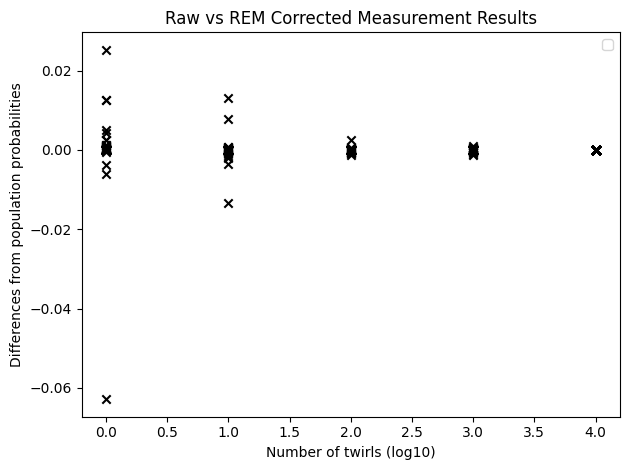

In [13]:
import matplotlib.pyplot as plt

print(distributions)
raw_counts = raw_results[0]
corrected_counts = res

bars = [f"{k:0{num_qubits}b}" for k in range(dim)]

data = np.array([[distributions[i].get(state, 0) for state in bars] for i in range(len(distributions))])
data = data - data[-1,:] # broadcast the final entries 
data = data[:,:]
plt.figure()
# for i in range(len(distributions)-1):
for i in range(len(bars)):
    plt.scatter(range(len(distributions)), data[:,i], c= 'k', marker ='x')
    # plt.hist(data[i,:], bins = 50)
plt.xlabel('Number of twirls (log10)')
plt.ylabel('Differences from population probabilities')
plt.title('Raw vs REM Corrected Measurement Results')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
for i,n in enumerate(n_twirls[:-1]):    
    errors = data[:,i]
    print(f"errors (from largest result) across 10^{int(np.log10(n))} twirl(s): {np.average(errors):+.3f} +/- {np.std(errors):.3f}")

errors (from largest result) across 10^0 twirl(s): -0.010 +/- 0.027
errors (from largest result) across 10^1 twirl(s): +0.001 +/- 0.006
errors (from largest result) across 10^2 twirl(s): -0.000 +/- 0.002
errors (from largest result) across 10^3 twirl(s): +0.000 +/- 0.000


This distribution will look different for various noise models and realistic devices (in particular, symmetric noise would be a constant). Here we can see that the amplitude damping noise, which biases the measurement result towards a particular state, is effectively mitigated. 

When considering the precision, we see that even 10 twirls well approximates the mean, and at 100 twirls our standard deviations is below our expected sampling threshold of 0.001. 

#### Applying Twirls Results

Now, taking the 10 - 100 twirled result as our baseline, we can use this distribution to inform our noise model. Let's take 4096 shots with 64 twirls, targetting a noise precision of 0.016. 



In [15]:
total_shots = 4096
total_twirls = 64

circuit = Circuit()
for i in range(num_qubits):
    circuit.z(i)

distributions = []
variants, masks  = apply_readout_twirl(circuit, total_twirls)
masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]
variants = [qd2._noise_model.apply(v.measure(range(num_qubits))) for v in variants]

# form program set

pset = ProgramSet(variants, shots_per_executable= total_shots//total_twirls)
results = qd2.run(pset).result()

base = {}
for item, mask in zip(results, masks):
    for k, v in item.entries[0].probabilities.items():
        kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
        base[kp] = base.get(kp, 0) + v

# Normalize
base = {k: v/total_twirls for k, v in base.items()}

distributions.append(base)
print(base)



/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/circuits/noise_model/noise_model.py:299: UserWarning: A noise model is being applied to a circuit that already has noise instructions.
  new_programs.append(self._apply_to_circuit(program, allow_warning=(not n)))


{'000001': 0.072509765625, '000000': 0.454833984375, '010000': 0.055908203125, '010100': 0.005859375, '000100': 0.038818359375, '110100': 0.000732421875, '000010': 0.041748046875, '001000': 0.06689453125, '100000': 0.10498046875, '000011': 0.007568359375, '100001': 0.018798828125, '000101': 0.006591796875, '001010': 0.008056640625, '001100': 0.00439453125, '100100': 0.009033203125, '011100': 0.0009765625, '110110': 0.000244140625, '010010': 0.005615234375, '101000': 0.0166015625, '110010': 0.001220703125, '100010': 0.011474609375, '110000': 0.015869140625, '001001': 0.00927734375, '011000': 0.008544921875, '110001': 0.003173828125, '011010': 0.0009765625, '010001': 0.010498046875, '000110': 0.00341796875, '101001': 0.00341796875, '110101': 0.000244140625, '100011': 0.0009765625, '001011': 0.000732421875, '101011': 0.000244140625, '001101': 0.0009765625, '100101': 0.00048828125, '110011': 0.000244140625, '111000': 0.001220703125, '010110': 0.000244140625, '010101': 0.00048828125, '10011

From this distribution, we can obtain marginal distributions by summing over bitstrings. The relevant marginals we are interested are the single qubit bit flip probabilties. 
We can calculate these, and then convert them to a inverse distribution using mitiq. 

In [16]:
from functools import reduce

qubit_tallies = [0]*num_qubits
for i in range(num_qubits):
    for k,v in base.items():
        if k[i] == '1':
            qubit_tallies[i] += v

confusion_matrix = np.array([])

mats = [generate_inverse_confusion_matrix(1,p0=i,p1=i) for i in qubit_tallies]
print("Average single qubit bit flip rates")
print(qubit_tallies)
mat = reduce(np.kron, mats, np.array([[1]]))
print("Tensored inverse confusion matrix: ")
for i in range(dim):
    print(mat[:,i])

Average single qubit bit flip rates
[0.192138671875, 0.11474609375, 0.125244140625, 0.075927734375, 0.086669921875, 0.1396484375]
Tensored inverse confusion matrix: 
[ 2.528 -0.41  -0.24   0.039 -0.208  0.034  0.02  -0.003 -0.362  0.059  0.034 -0.006  0.03  -0.005 -0.003  0.    -0.328  0.053  0.031 -0.005  0.027 -0.004 -0.003  0.     0.047 -0.008 -0.004  0.001 -0.004  0.001  0.    -0.    -0.601  0.098  0.057 -0.009  0.049 -0.008 -0.005  0.001  0.086 -0.014 -0.008  0.001 -0.007  0.001  0.001 -0.     0.078 -0.013 -0.007  0.001 -0.006  0.001  0.001 -0.    -0.011
  0.002  0.001 -0.     0.001 -0.    -0.     0.   ]
[-0.41   2.528  0.039 -0.24   0.034 -0.208 -0.003  0.02   0.059 -0.362 -0.006  0.034 -0.005  0.03   0.    -0.003  0.053 -0.328 -0.005  0.031 -0.004  0.027  0.    -0.003 -0.008  0.047  0.001 -0.004  0.001 -0.004 -0.     0.     0.098 -0.601 -0.009  0.057 -0.008  0.049  0.001 -0.005 -0.014  0.086  0.001 -0.008  0.001 -0.007 -0.     0.001 -0.013  0.078  0.001 -0.007  0.001 -0.006 -0. 

#### On the Variance of Measurement Inversion and Post Selection

REM techniques generally affect the variance of othe output distribution. This is essentially because the inverse matrix has a norm larger than the indentity, i.e. you are expanding some contractive stochastic mapping. From [previous work](https://arxiv.org/pdf/2006.14044), we can see that the variance for a tensor product of single qubit probabilities increases the variance by:

$$ \gamma =  \prod_{j=1}^n \frac{1}{1 - 2 p_j}$$

where $p_j$ is the effective bitflip error rate.

Below, we calculate the $\gamma$ factor for our above single bit-flip model. This implies that we need to increase our shots by a factor of $\gamma^2$ to decrease the precision by $\gamma$.  

In [17]:
gamma = reduce(lambda x,y: x*y,[1/ (1- 2*pi) for pi in qubit_tallies], 1)

print(f"gamma factor: {gamma}")

gamma factor: 5.565524700180994


Under the method here, with some assumptions, we find that generally if we learn the probabilities $p_i$ to precision $1/\sqrt{N}$, then we expect a bias in our result of $\frac{\gamma}{\sqrt{N}}$. The additional factor of $\gamma$ is due to the fact that it itself functionally depends on $\hat p_i$, and has a related propagation of error. Thus, to suppress this, we would ideally learn the noise with $\gamma^2 N$ shots. 

However, we can be optimistic as well. This is some what of a worst-case applied to a fully $n-$qubit observable which depend on all states. This can occur for non-local fermion-to-qubit mappings like Jordan-Wigner, but $k-$ local observables this is effectively mitigated. Note, bitstrings by comparison are fully $n-$local. For our local case, we can define a worst case gamma,

$$ \gamma^*(O) = \max_{I \in O} \prod_{j \in I} \frac{1}{1 - 2 p_j} $$

where $I$ is a vector or set of indices corresponding to observables within $O$ we are measuring. Thus, a sufficient overhead is ${\gamma^*}^2$. 




### Conclusion

In this notebook we showed how we can perform readout error mitigation with mitiq using Amazon Braket. We show standard brute-force characterization techniques, as well as a twirled variant which can be applied to distribution throgh the inverse confusion matrix. Interested readers are encouraged to view further references below and at the [mitiq repository](https://mitiq.readthedocs.io/en/stable/guide/rem.html). 

### References 

1. Unitary Foundation, [**mitiq.rem documentation**](https://mitiq.readthedocs.io/en/stable/guide/rem.html). Accessed 12/9/2025. 
2. Bravyi et al., [**Mitigiating measurement errors in multi-qubit experiments**](https://arxiv.org/pdf/2006.14044) (2021) Phys. Rev. A., 103, 042605. 
3. Hashim et al., [**Quasiprobabilistic Readout Correction of Midcircuit Measurements for Adaptive Feedback via Measurement Randomized Compiling**](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.6.010307) (2025) PRX Quantum, 6, 010307. 
4. Sagastizabal et al., [Experimental error mitigation via symmetry verification in a variational quantum eigensolver](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.010302) 2019, Phys. Rev. A, 100, 010302. 